# Machine Learning Phases of Matter (with Discriminative Localization)

This project reproduces results from the article "Machine Learning Phases of Matter" (https://arxiv.org/abs/1605.01735), in addition to exploring the application of discriminative localization (https://arxiv.org/pdf/1512.04150.pdf) to this area of study. The first article shows how neural networks, including fully connected networks (FCN) and convolutional neural networks (CNN), can be used to infer macroscopic information about a statistical mechanical system's state from its microstate. The focus here is on the particular case of the Ising model, and inferring the phase of the system from its underlying spin configuration. This project applies the results of the second article on discriminative localization to investigate the decision regions that determine the classification of Ising configuration by a CNN (including a global average pooling layer before the final dense/softmax layers) as being in the polarized or unpolarized phase.  

The data of the Ising model is simulated for various temperatures around the critical temperature $T_c = 2.27$, at which the phase transition from disordered (unpolarized, spins pointing in random directions) to ordered (polarized, spins pointing in roughly the same direction). The simulation is performed using the Metropolis algorithm, a well-known form of Markov chain Monte Carlo (MCMC).  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import backend as K

Using TensorFlow backend.


## Generate Data

Simulate Ising model congiuration data using the Metropolis MCMC algorithm (see e.g. https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

In [136]:
'''

J = 1  # coupling strength
L = 32  # grid size

temperatures = np.arange(1, 3.51, 0.1)
ntherm = 100  # thermalization steps
nsamples = 100  # number of samples for every starting configuration
nbin = 10  # number of starting configurations

n = len(temperatures) * nbin * nsamples  # total number of samples

C = np.empty((n, L, L))
T = np.empty(n)

# checkerboard pattern
x = np.zeros((L, L), dtype=int)
x[1::2, 0::2] = 1
x[0::2, 1::2] = 1

c = 0
for t in temperatures:
    print(t)
    for i in range(nbin):
        # start with polarized state
        grid = np.ones((L, L)) * (-1)**(i % 2)
        # draw a number of sample configurations
        for j in range(nsamples):
            # perform a number of updates until thermalization
            for k in range(ntherm):
                neighbors = np.roll(grid, +1, axis=0) + \
                            np.roll(grid, -1, axis=0) + \
                            np.roll(grid, +1, axis=1) + \
                            np.roll(grid, -1, axis=1)
                # calculate the potential changes in energy
                dE = 2 * J * (grid * neighbors)
                # calculate the transition probabilities
                p = np.exp(-dE / t)
                # decide which transitions will occur
                # (avoid updating neighbors using alternating checkerboard pattern)
                grid *= 1 - 2 * np.multiply(np.int8(np.random.rand(L, L) < p), x ^ (k % 2))

            C[c] = grid
            T[c] = t
            c += 1

# shuffle and save data
p = np.random.permutation(len(C))
np.savez_compressed('data.npz', X=C[p], y=T[p])
'''

"\n\nJ = 1  # coupling strength\nL = 32  # grid size\n\ntemperatures = np.arange(1, 3.51, 0.1)\nntherm = 100  # thermalization steps\nnsamples = 100  # number of samples for every starting configuration\nnbin = 10  # number of starting configurations\n\nn = len(temperatures) * nbin * nsamples  # total number of samples\n\nC = np.empty((n, L, L))\nT = np.empty(n)\n\n# checkerboard pattern\nx = np.zeros((L, L), dtype=int)\nx[1::2, 0::2] = 1\nx[0::2, 1::2] = 1\n\nc = 0\nfor t in temperatures:\n    print(t)\n    for i in range(nbin):\n        # start with polarized state\n        grid = np.ones((L, L)) * (-1)**(i % 2)\n        # draw a number of sample configurations\n        for j in range(nsamples):\n            # perform a number of updates until thermalization\n            for k in range(ntherm):\n                neighbors = np.roll(grid, +1, axis=0) +                             np.roll(grid, -1, axis=0) +                             np.roll(grid, +1, axis=1) +                        

## Data Import and Exploration

In [5]:
def load_and_split_data():
    data = np.load('data.npz')
    X = data['X']
    y = data['y']
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    X_train, X_test = np.split(X, [22000])
    y_train, y_test = np.split(y, [22000])
    return X_train, y_train, X_test, y_test

In [6]:
X_train, Y_train, X_test, Y_test = load_and_split_data()

X.shape: (26000, 32, 32)
y.shape: (26000,)


In [4]:
def plot_examples(X, y, n_examples=10):
    temperatures = np.arange(1.0, 3.6, .1)
    fig, axes = plt.subplots(n_examples, len(temperatures), figsize=(len(temperatures), n_examples))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, hspace=.01, wspace=.01)
    #print(axes)
    for i in range(len(temperatures)):
        t = temperatures[i]
        mask_t = y == t
        X_t = X[mask_t]
        for n in range(n_examples):
            image = X_t[n]
            axes[n,i].imshow(image, cmap='Greys', origin='upper')
    fig.savefig('examples.jpg', cmap='Greys') 

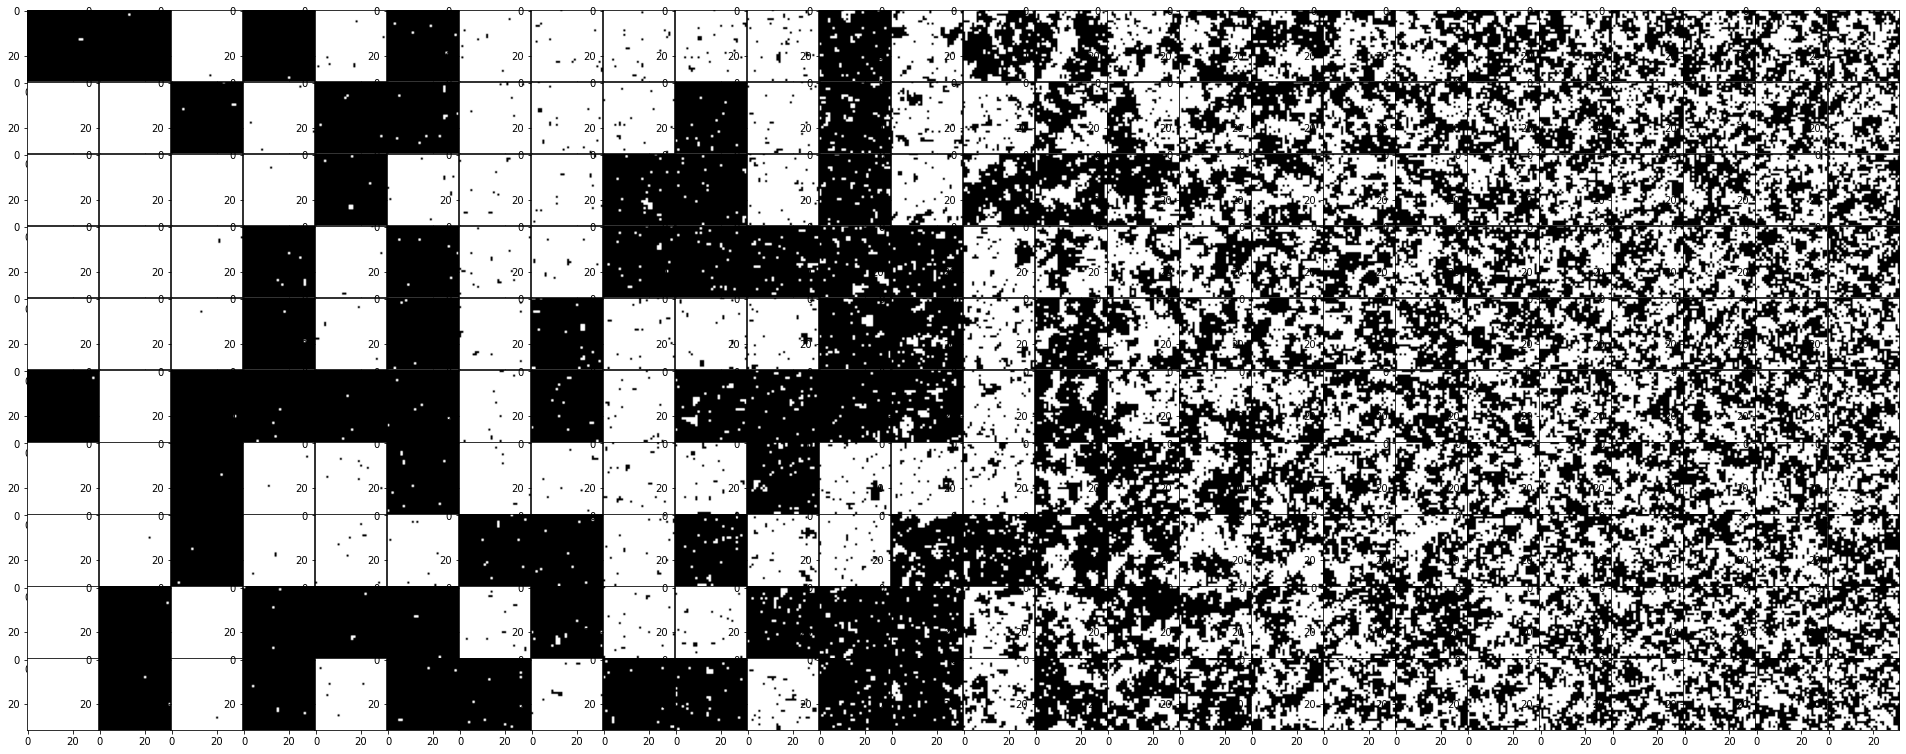

In [91]:
plot_examples(X_train, y_train)

## Data Preprocessing

In [7]:
def temp_to_label(y_temp):
    temperatures = np.arange(1.0, 3.6, .1)
    y_label = np.searchsorted(temperatures, y_temp)
    return y_label

def label_to_onehot(y_label, n_classes):
    if np.min(y_label) < 0 or np.max(y_label) >= n_classes:
        print('Error: n_classes not compatible with label_vector')
        return None
    y_onehot = np.zeros((len(y_label), n_classes))
    y_onehot[np.arange(len(y_label)), y_label] = 1 
    return y_onehot

def onehot_to_label(y_onehot):
    y_label = [np.where(row==1)[0][0] for row in y_onehot]
    return np.array(y_label)

def label_to_temp(y_label):
    temperatures = np.arange(1.0, 3.6, .1)
    y_temp = temperatures[y_label]
    return y_temp
    
def onehot_to_temp(y_onehot):
    y_temp = label_to_temp(onehot_to_label(y_onehot))
    return y_temp
    
    

In [8]:
temperatures = np.arange(1.0, 3.6, .1)
Tc = 2.27
n_temps = len(temperatures)
y_train = Y_train > Tc
y_train = label_to_onehot(y_train.astype(int), 2)
y_test = Y_test > Tc
y_test = label_to_onehot(y_test.astype(int), 2)

In [29]:
onehot_to_label(y_train)

array([0, 0, 1, ..., 0, 0, 0])

In [30]:
Y_train > Tc

array([False, False,  True, ..., False, False, False])

In [9]:
# True is [0,1], False is [1,0]
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [10]:
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

## Predict Phase with Toy Model

Classify phases with toy model with pre-specified weights, explicitly constructed to distinguish polarized (with magnetization $M \equiv \frac{1}{N}\sum_{i,j}s_{ij}$ such that $M > \epsilon$ or $M < - \epsilon$) from unpolarized (between -$\epsilon$ and + $\epsilon$). The only free parameter of this model is $\epsilon$.

In [9]:
def accuracy(yp, y):
    N = y.shape[0] # number of examples
    acc = (1./N) * np.trace(np.dot(yp,y.T))
    return acc

def heaviside(X):
    X[X >= 0] = 1
    X[X < 0] = 0
    return X
        
def toy_model(X, eps): # apply to a Nx32x32 stack of images
    m = X.shape[1]*X.shape[2]
    X = X.reshape((-1,m)) # un
    
    W1 = (1./m) * np.stack((np.ones((m,)),-np.ones((m,)), np.ones((m,))))
    W1 = (1./(1.+eps)) * W1
    b1 = np.array([-1,-1, 1])
    b1 = (eps/(1.+eps)) * b1
    
    h1 = np.dot(X, W1.T) + b1
    h1 = heaviside(h1)
    
    W2 = np.stack(([2, 1, -1], [-2, -2, 1]))
    
    h2 = np.dot(h1, W2.T)
    y = heaviside(h2)
    
    return y 

Use the training set to find the best value for $\epsilon$, then evaluate the toy model on the test set with this value of $\epsilon$ found on the training set. 

0 / 100
epsilon: 0.0
train set accuracy: 0.49831818181818177
1 / 100
epsilon: 0.01
train set accuracy: 0.5304545454545454
2 / 100
epsilon: 0.02
train set accuracy: 0.5612272727272727
3 / 100
epsilon: 0.03
train set accuracy: 0.5904999999999999
4 / 100
epsilon: 0.04
train set accuracy: 0.6186363636363637
5 / 100
epsilon: 0.05
train set accuracy: 0.6459999999999999
6 / 100
epsilon: 0.06
train set accuracy: 0.6724545454545454
7 / 100
epsilon: 0.07
train set accuracy: 0.697
8 / 100
epsilon: 0.08
train set accuracy: 0.7212727272727272
9 / 100
epsilon: 0.09
train set accuracy: 0.7464090909090909
10 / 100
epsilon: 0.1
train set accuracy: 0.7665
11 / 100
epsilon: 0.11
train set accuracy: 0.7841818181818181
12 / 100
epsilon: 0.12
train set accuracy: 0.8001363636363635
13 / 100
epsilon: 0.13
train set accuracy: 0.8144090909090909
14 / 100
epsilon: 0.14
train set accuracy: 0.8281818181818181
15 / 100
epsilon: 0.15
train set accuracy: 0.8409545454545454
16 / 100
epsilon: 0.16
train set accuracy: 0

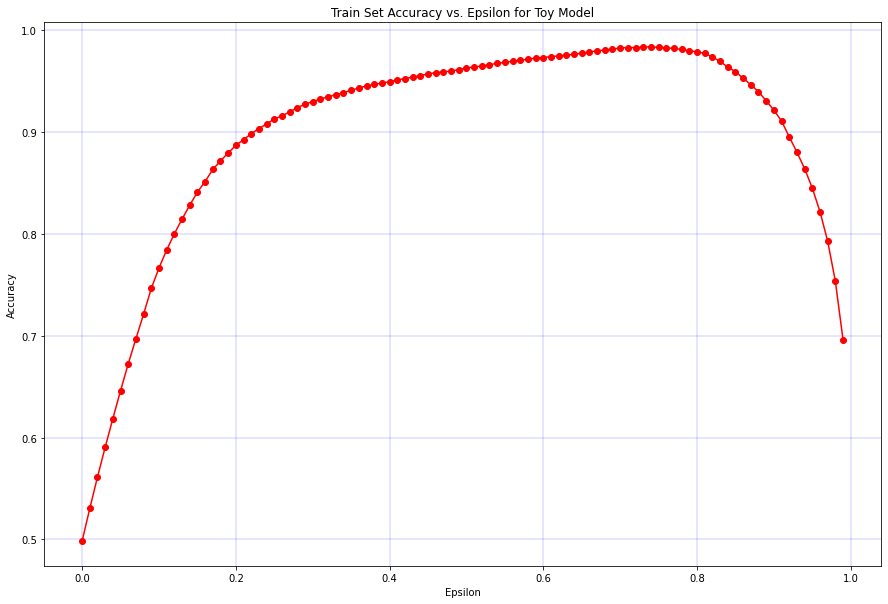

In [98]:
epsilons = np.arange(0.00, 1.00, 0.01)
accuracies = np.zeros(epsilons.shape[0])
for i, eps in enumerate(epsilons):
    print(i,'/', len(epsilons))
    print('epsilon:', eps)
    accuracies[i] = accuracy(toy_model(X_train, eps), y_train)
    print('train set accuracy:', accuracies[i])
i_best = np.argmax(accuracies)
eps_best = epsilons[i_best]
train_accuracy_best = accuracies[i_best]
print('Best train set epsilon: ' + str(eps_best))
print('Best train set accuracy: ' + str(train_accuracy_best))

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(epsilons, accuracies, marker = 'o', color = 'r')
ax.set_xlabel('Epsilon')
ax.set_ylabel('Accuracy')
ax.set_title('Train Set Accuracy vs. Epsilon for Toy Model')
ax.grid(color='b', linewidth=.2)
plt.show()
fig.savefig('output/accuracy_v_epsilon_toy_model.jpg')

In [99]:
test_accuracy = accuracy(toy_model(X_test, eps_best), y_test)
print('Test set accuracy: ' + str(test_accuracy))

Test set accuracy: 0.9825


Best value of $\epsilon$ from train set is $.74$. Accuracy on test set of toy model defined with this $\epsilon$ is $.9825$. Compare this value to performance of neural nets below. 

## Predict Phase with Fully Connected Neural Network (FCN)

### Single Layer FCN model with 3 Neurons

In [104]:
num_neurons = 3

model = Sequential()
model.add(Flatten(input_shape=(32, 32)))
model.add(Dense(num_neurons, activation='sigmoid', input_shape=(1024,)))
model.add(Dense(2, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    
model.fit(
    X_train,
    y_train, 
    batch_size = 128,
    epochs = 50,
    verbose = 0,
    validation_split = 0.15,
    callbacks=[
        EarlyStopping(patience=3, verbose=1),
        ReduceLROnPlateau(factor=0.6, patience=2, verbose=0),
        CSVLogger('output/trainHistory_FCN_{}.csv'.format(num_neurons))
        ]
    )
model.save('output/model_FCN_{}.h5'.format(num_neurons))


Epoch 00050: early stopping


In [105]:
model = load_model('output/model_FCN_{}.h5'.format(num_neurons))    

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss: ' + str(score[0]))
print('Test accuracy: ' + str(score[1]))

Test loss: 0.12624173814058304
Test accuracy: 0.9651250243186951


**Note:** If time, come back and plot the pre-activation values of hidden layer and compare to toy model, as in Carrasquilla/Melko paper. 

Actually does worse than the toy model on the test set. 

### Hyperparameter Grid Search on Single-Layer FCNs

sklearn's GridSearchCV has trouble with hyperparameters in training callback functions, so just do the grid search by hand. Here, the test set is being used as a validation set of sorts to select among the different single-layer FCN models. 

In [157]:
# grid search 
num_neurons = [3, 32, 128]
activations = ['sigmoid', 'relu']
lr_reduction_factors = [.33, .67]
scores_dict = {}
for i in range(len(num_neurons)):
    for j in range(len(activations)):
        for k in range(len(lr_reduction_factors)):
            print('')
            print('Hyperparameters: ', num_neurons[i], activations[j], lr_reduction_factors[k])
            model = Sequential()
            model.add(Flatten(input_shape=(32, 32)))
            model.add(Dense(units=num_neurons[i], activation=activations[j], input_shape=(1024,)))
            model.add(Dense(2, activation='sigmoid'))
            
            model.compile(
                loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
                
            model.fit(
                X_train,
                y_train, 
                batch_size = 128,
                epochs = 50,
                verbose = 0,
                validation_split = 0.1,
                callbacks=[
                    EarlyStopping(patience=3, verbose=1),
                    ReduceLROnPlateau(factor=lr_reduction_factors[k], patience=2, verbose=0),
                    CSVLogger('output/trainHistory_FCN_{}_{}_{}.csv'.format(num_neurons[i], activations[j], lr_reduction_factors[k]))
                    ]
                )
            score = model.evaluate(X_test, y_test, verbose=0)
            print('test set loss:', score[0])
            print('test set accuracy:', score[1])
            # store accuracies in a dict
            scores_dict[(num_neurons[i], activations[j], lr_reduction_factors[k])] = score
            model.save('output/model_FCN_{}_{}_{}.h5'.format(num_neurons[i], activations[j], lr_reduction_factors[k]))



Hyperparameters:  3 sigmoid 0.33
Epoch 00047: early stopping
test set loss: 0.1281554251909256
test set accuracy: 0.9652500152587891

Hyperparameters:  3 sigmoid 0.67
test set loss: 0.13328950634598732
test set accuracy: 0.9649999737739563

Hyperparameters:  3 relu 0.33
Epoch 00021: early stopping
test set loss: 0.3329699640274048
test set accuracy: 0.8773750066757202

Hyperparameters:  3 relu 0.67
Epoch 00038: early stopping
test set loss: 0.1614599790275097
test set accuracy: 0.9537500143051147

Hyperparameters:  32 sigmoid 0.33
Epoch 00022: early stopping
test set loss: 0.08596542017906904
test set accuracy: 0.9700000286102295

Hyperparameters:  32 sigmoid 0.67
Epoch 00020: early stopping
test set loss: 0.09130322113633156
test set accuracy: 0.968874990940094

Hyperparameters:  32 relu 0.33
Epoch 00007: early stopping
test set loss: 0.07203474122844636
test set accuracy: 0.9756249785423279

Hyperparameters:  32 relu 0.67
Epoch 00007: early stopping
test set loss: 0.0727344636972993

In [132]:
best_acc = max([scores_dict[key][1] for key in scores_dict.keys()])
for key, value in scores_dict.items():
    if value[1] == best_acc:
        best_params = key
print('Best Parameters: ', best_params)
print('Test Accuracy of Model with Best Parameters: ', best_acc)

Best Parameters:  (128, 'relu', 0.33)
Test Accuracy of Model with Best Parameters:  0.9762499928474426


Some improvement over 3-neuron single-layer FCN.

### Multi-Layer FCN

Apply multi-layer FCN just to get a sense of how this might affect performance. No grid search this time, since that didn't seem to make much difference.

In [110]:
num_neurons_1 = 128
num_neurons_2 = 128
model = Sequential()
model.add(Flatten(input_shape=(32, 32)))
model.add(Dense(num_neurons_1, activation='relu', input_shape=(1024,)))
model.add(Dense(num_neurons_2, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    
model.fit(
    X_train,
    y_train, 
    batch_size = 128,
    epochs = 50,
    verbose = 0,
    validation_split = 0.1,
    callbacks=[
        EarlyStopping(patience=3, verbose=0),
        ReduceLROnPlateau(factor=.7, patience=2, verbose=1)
        #CSVLogger('results/trainHistory_FCN_{}.csv'.format(num_neurons))
        ]
    )
model.save('output/model_FCN_{}_{}_{}_{}.h5'.format(num_neurons_1, num_neurons_2, 'sigmoid', .7))

model = load_model('output/model_FCN_{}_{}_{}_{}.h5'.format(num_neurons_1, num_neurons_2, 'sigmoid', .7))    

score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss: ' + str(score[0]))
print('Test accuracy: ' + str(score[1]))


Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
4000/4000 [==============================] - 0s 26us/step
Test loss: 0.09670515855413396
Test accuracy: 0.9757500290870667


## CNN

In [111]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

# model and training
model = Sequential()
model.add(Convolution2D(16, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 1)))
model.add(Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Convolution2D(64, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])
    
history = model.fit(
    X_train, y_train,
    batch_size=128,
    epochs=50,
    verbose=2,
    validation_split=0.1,
    callbacks=[
        EarlyStopping(patience=5, verbose=1),
        ReduceLROnPlateau(factor=0.67, patience=2, verbose=1),
        CSVLogger('output/history_CNN.csv')])

score = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', score[0])
print('Test accuracy', score[1])
model.save('output/model_CNN.h5')

Train on 19800 samples, validate on 2200 samples
Epoch 1/50
 - 38s - loss: 0.0986 - accuracy: 0.9582 - val_loss: 0.0599 - val_accuracy: 0.9718
Epoch 2/50
 - 37s - loss: 0.0390 - accuracy: 0.9838 - val_loss: 0.0342 - val_accuracy: 0.9868
Epoch 3/50
 - 37s - loss: 0.0372 - accuracy: 0.9848 - val_loss: 0.0385 - val_accuracy: 0.9827
Epoch 4/50
 - 37s - loss: 0.0365 - accuracy: 0.9846 - val_loss: 0.0338 - val_accuracy: 0.9859
Epoch 5/50
 - 37s - loss: 0.0351 - accuracy: 0.9859 - val_loss: 0.0499 - val_accuracy: 0.9759
Epoch 6/50
 - 37s - loss: 0.0356 - accuracy: 0.9856 - val_loss: 0.0442 - val_accuracy: 0.9795

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
Epoch 7/50
 - 37s - loss: 0.0341 - accuracy: 0.9865 - val_loss: 0.0356 - val_accuracy: 0.9841
Epoch 8/50
 - 37s - loss: 0.0337 - accuracy: 0.9862 - val_loss: 0.0411 - val_accuracy: 0.9814

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
Epoch 9/50
 - 37s - loss: 0.0334 - ac

CNN gives best result so far. 

## Plot Test Accuracy vs. Temperature

In [187]:
Y_test = np.around(Y_test,1)
mask = Y_test == round(2.3,1)
len(y_test[mask])

152


t 1.0
170 rows
toy_model_0.74
temperature t accuracy: 1.0
model_FCN_128_relu_0.33
170/170 [==============================] - 0s 121us/step
temperature t accuracy: 1.0
model_FCN_128_128_sigmoid_0.7
170/170 [==============================] - 0s 118us/step
temperature t accuracy: 1.0
model_CNN
170/170 [==============================] - 0s 660us/step
temperature t accuracy: 1.0

t 1.1
162 rows
toy_model_0.74
temperature t accuracy: 1.0
model_FCN_128_relu_0.33
162/162 [==============================] - 0s 125us/step
temperature t accuracy: 1.0
model_FCN_128_128_sigmoid_0.7
162/162 [==============================] - 0s 146us/step
temperature t accuracy: 1.0
model_CNN
162/162 [==============================] - 0s 629us/step
temperature t accuracy: 1.0

t 1.2
165 rows
toy_model_0.74
temperature t accuracy: 1.0
model_FCN_128_relu_0.33
165/165 [==============================] - 0s 122us/step
temperature t accuracy: 1.0
model_FCN_128_128_sigmoid_0.7
165/165 [==============================] - 0s 

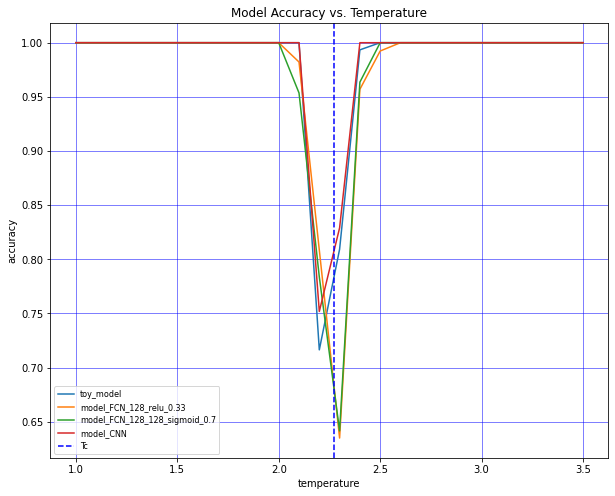

<Figure size 432x288 with 0 Axes>

In [190]:
model_names = ['toy_model', 'model_FCN_128_relu_0.33', 'model_FCN_128_128_sigmoid_0.7', 'model_CNN']
model_accuracies = {name: [] for name in model_names}
eps_best = .74
Y_test = np.around(Y_test,1)

for t in temperatures:
    print('')
    print('t', round(t,1))
    mask = Y_test == round(t,1)
    print(sum(mask), 'rows')
    y_test_t = y_test[mask]
    X_test_t = X_test[mask]
    
    toy_model_accuracy_t = accuracy(toy_model(X_test_t, eps_best), y_test_t)
    model_accuracies['toy_model'].append(toy_model_accuracy_t)
    print('toy_model_{}'.format(eps_best))
    print('temperature t accuracy:', np.float(toy_model_accuracy_t))
    # fill in accuracies for neural net models
    for name in model_names[1:]:
        print(name)
        model = load_model('output/{}.h5'.format(name))
        X_test_t = np.squeeze(X_test_t)
        if 'CNN' in name:
            X_test_t = np.expand_dims(X_test_t, axis=3)
        score = model.evaluate(X_test_t, y_test_t)
        model_accuracies[name].append(score[1])
        print('temperature t accuracy:', np.float(score[1]))
    
Tc = 2.27
fig, ax = plt.subplots(figsize=(15,10))
for name in model_accuracies.keys():
    ax.plot(temperatures, model_accuracies[name], label=name)
ax.axvline(x=Tc, color='b', linestyle='--', label = 'Tc')
ax.set_xlabel('temperature')
ax.set_ylabel('accuracy')
ax.set_title('Model Accuracy vs. Temperature')
ax.grid(color='b', linewidth=.5)
ax.legend(prop={'size': 8})
plt.show()
plt.savefig('output/model_accuracies_vs_temperature.jpg')

We expect that accuracy of all models will decrease close to the critical temperature since the configurations in the polarized phase look increasingly like those in the unpolarized phase near this boundary. 

Also, the plot shows that the CNN (red) is most accurate near the critical temperature. Intuitively, it makes sense that CNN would have the best performance since they are naturally suited to the 2D local structure of the Ising lattice. 

## Discriminative Localization

Discriminative localization enables us to determine specifically which regions/pixels in an image are most important to identifying the image as one or another class. Here we apply it to the images of the Ising model configurations to determine which pixel regions are most important to classifying the phase of the configuration. Discriminative localization is performed by computing the *class activation map* (CAM) of the CNN on the image. The CAM is defined as follows. Let $f_k(x,y)$ be the activation of the $k^{th}$ filter at the pixel with coordinates $(x,y)$ in the last convolution layer of the network, which is followed by a global average pooling (GAP) and then a dense and softmax output layer. The GAP layer, which computes the average of the activation at $(x,y)$ for each filter, yields 

\begin{equation}
F_{k} = \sum_{x,y}f_{k}(x,y). 
\end{equation}

The logit $z^c$ corresponding to class $c$ for the final dense layer is 

\begin{align}
z^c &= \sum_{k} w^c F_{k} \\
&= \sum_{k} w_k^c \sum_{x,y}f_{k}(x,y)\\
&= \sum_{x,y} \sum_{k} w_k^c f_{k}(x,y) \\
&= \sum_{x,y} M^c(x,y)
\end{align}

where 

\begin{equation}
M^c(x,y) \equiv \sum_{k} w_k^c f_{k}(x,y). 
\end{equation}

$M^c(x,y)$ is clearly a measure of the contribution of the pixel $(x,y)$ to the probability that the network assigns to class $c$. 

Here, we pick out several correctly classified and several incorrectly classified images of Ising configurations and use the CAM from our trained CNN to determine which regions of the image figure most importantly into each class decision. 

t 2.1
number of observations with temperature t: 140
number correct: 140
number incorrect: 0
proportion correct:  1.0
proportion incorrect:  0.0
t 2.2
number of observations with temperature t: 141
number correct: 106
number incorrect: 35
proportion correct:  0.75177304964539
proportion incorrect:  0.24822695035460995
t 2.3
number of observations with temperature t: 152
number correct: 126
number incorrect: 26
proportion correct:  0.8289473684210527
proportion incorrect:  0.17105263157894735
t 2.4
number of observations with temperature t: 151
number correct: 151
number incorrect: 0
proportion correct:  1.0
proportion incorrect:  0.0

M.shape: (1, 16, 16, 2)
M.shape: (1, 16, 16, 2)
M.shape: (1, 16, 16, 2)
M.shape: (1, 16, 16, 2)
M.shape: (1, 16, 16, 2)
M.shape: (1, 16, 16, 2)


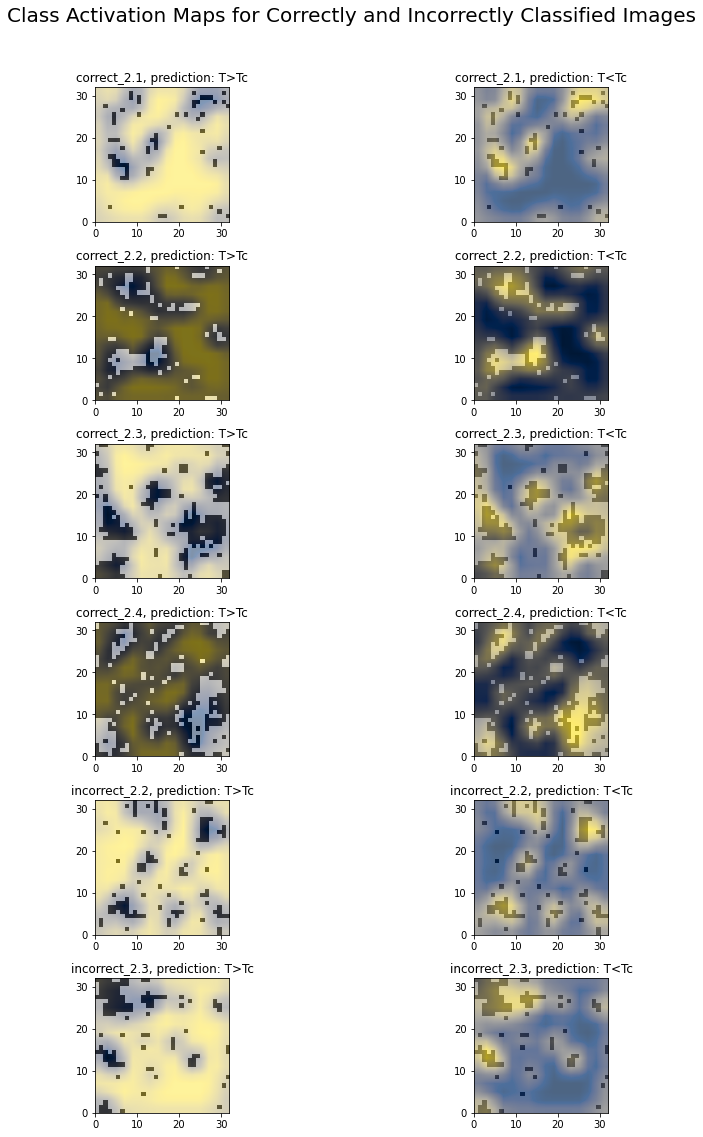

In [10]:
Y_test = np.around(Y_test,1)
y_test = onehot_to_label(y_test)
#print(type(y_test))

boundary_temps = [2.1, 2.2, 2.3, 2.4] # look at data with these temps for false predictions
model = load_model('output/model_CNN.h5')

test_correct = dict.fromkeys(boundary_temps)
test_incorrect = dict.fromkeys(boundary_temps)

for t in boundary_temps:
    print('t', t)
    mask = Y_test == round(t, 1)
    X_test_t = np.expand_dims(X_test[mask], axis=3)
    y_test_t = y_test[mask]
    yp_test_t = model.predict(X_test_t)[:,1] > .5
    correct_pred = yp_test_t == y_test_t
    
    n_t = y_test_t.shape[0]
    prop_correct_t = np.sum(correct_pred)/n_t
    print('number of observations with temperature t:', n_t)
    print('number correct:', np.sum(correct_pred))
    print('number incorrect:', n_t - np.sum(correct_pred))
    print('proportion correct: ', prop_correct_t)
    print('proportion incorrect: ', 1-prop_correct_t)
    
    X_test_correct_t = X_test_t[correct_pred]
    y_test_correct_t = y_test_t[correct_pred]
    test_correct[t] = [X_test_correct_t, y_test_correct_t]
    
    X_test_incorrect_t = X_test_t[~correct_pred]
    y_test_incorrect_t = y_test_t[~correct_pred]
    test_incorrect[t] = [X_test_incorrect_t, y_test_incorrect_t]


# create dictionary of two correct images and two incorrect images to display, one from each side of Tc
#display = {'correct_2.2': test_correct[2.2][0][0, ...], 'correct_2.3': test_correct[2.3][0][0, ...], 'incorrect_2.2': test_incorrect[2.2][0][0, ...], 'incorrect_2.3': test_incorrect[2.3][0][0, ...]}
# no incorrect images for temp 2.4
display = {'correct_2.1': test_correct[2.1][0][0, ...], 'correct_2.2': test_correct[2.2][0][0, ...], 'correct_2.3': test_correct[2.3][0][0, ...], 'correct_2.4': test_correct[2.4][0][0, ...], 'incorrect_2.2': test_incorrect[2.2][0][0, ...], 'incorrect_2.3': test_incorrect[2.3][0][0, ...]}


## calculate and plot class activation maps (CAMs) for the four images (2 maps for each image, one for > Tc, one for < Tc) 

#print(model.layers)
last_conv_layer = model.layers[-3]

inputs = [K.learning_phase()] + model.inputs

activation_func = K.function(inputs, [last_conv_layer.output])

# Get weights connecting output of GAP layer to final dense softmax layer
W, b = model.layers[-1].get_weights()

print('')

# plot class activation maps
fig, axes = plt.subplots(6, 2, figsize=(15, 15))
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, hspace=.1, wspace=.1)

for i in range(len(display)):
    key = list(display.keys())[i]
    X_in = np.expand_dims(display[key], axis=0)
    #print('X_in.shape:', X_in.shape)
    f,  = activation_func([0] + [X_in])
    # Define class activation map for both classes. 
    # M contains two 16x16 activation maps: 0 index for T>Tc, 1 index for T<Tc
    M = np.einsum('ixyz,zc->ixyc', f, W) + b
    print('M.shape:', M.shape)
    ax1 = axes.flat[2*i]
    ax2 = axes.flat[2*i+1]
    ax1.imshow(np.squeeze(X_in), cmap='Greys', extent=(0, 32, 0, 32))
    ax1.imshow(np.squeeze(M[:,:,:,0]), interpolation='bilinear', alpha=.5, extent=(0, 32, 0, 32), cmap='cividis')
    ax2.imshow(np.squeeze(X_in), cmap='Greys', extent=(0, 32, 0, 32))
    ax2.imshow(np.squeeze(M[:,:,:,1]), interpolation='bilinear', alpha=.7, extent=(0, 32, 0, 32), cmap='cividis')
    ax1.set_title(key + ', prediction: T>Tc')
    ax2.set_title(key + ', prediction: T<Tc')

fig.suptitle('Class Activation Maps for Correctly and Incorrectly Classified Images', y = 1.05, fontsize=20)
fig.tight_layout()
plt.show()
plt.savefig('output/CAMs.jpg')
plt.close()


For each image, show ground truth and prediction probabilities output by CNN. 

In [28]:

Y_test = np.around(Y_test,1)
#y_test = onehot_to_label(y_test)
#print(type(y_test))

boundary_temps = [2.1, 2.2, 2.3, 2.4] # look at data with these temps for false predictions
model = load_model('output/model_CNN.h5')

test_correct = dict.fromkeys(boundary_temps)
test_incorrect = dict.fromkeys(boundary_temps)

for t in boundary_temps:
    print('t', t)
    mask = Y_test == round(t, 1)
    X_test_t = np.expand_dims(X_test[mask], axis=3)
    y_test_t = y_test[mask]
    y_probs_t = model.predict(X_test_t)
    yp_test_t = y_probs_t[:,1] > .5
    correct_pred = yp_test_t == y_test_t
    print('y_probs_t.shape:', y_probs_t.shape)
    n_t = y_test_t.shape[0]
    prop_correct_t = np.sum(correct_pred)/n_t
    print('number of observations with temperature t:', n_t)
    print('number correct:', np.sum(correct_pred))
    print('number incorrect:', n_t - np.sum(correct_pred))
    print('proportion correct: ', prop_correct_t)
    print('proportion incorrect: ', 1-prop_correct_t)
    
    X_test_correct_t = X_test_t[correct_pred]
    y_test_correct_t = y_test_t[correct_pred]
    yp_test_correct_t = yp_test_t[correct_pred]
    y_probs_correct_t = y_probs_t[correct_pred]
    test_correct[t] = [X_test_correct_t, y_test_correct_t, yp_test_correct_t, y_probs_correct_t]
    
    X_test_incorrect_t = X_test_t[~correct_pred]
    y_test_incorrect_t = y_test_t[~correct_pred]
    yp_test_incorrect_t = yp_test_t[~correct_pred]
    y_probs_incorrect_t = y_probs_t[~correct_pred]
    test_incorrect[t] = [X_test_incorrect_t, y_test_incorrect_t, yp_test_incorrect_t, y_probs_incorrect_t]


# create dictionary of two correct images and two incorrect images to display, one from each side of Tc
#display = {'correct_2.2': test_correct[2.2][0][0, ...], 'correct_2.3': test_correct[2.3][0][0, ...], 'incorrect_2.2': test_incorrect[2.2][0][0, ...], 'incorrect_2.3': test_incorrect[2.3][0][0, ...]}
# no incorrect images for temp 2.4

# 0: X, 1: y, 2: y_pred, 3: y_probs

display_correct = {'correct_{}'.format(boundary_temps[i]): [test_correct[boundary_temps[i]][j][0, ...] for j in range(4)] for i in range(len(boundary_temps))}
display_incorrect = {'incorrect_{}'.format(boundary_temps[i]): [test_incorrect[boundary_temps[i]][j][0, ...] for j in range(4)] for i in range(1,3)} # no incorrect predictions for temp 2.1 and 2.4
display = {**display_correct, **display_incorrect}

#print(display_incorrect)
print(display)

#display = {'correct_2.1': test_correct[2.1][0][0, ...], 'correct_2.2': test_correct[2.2][0][0, ...], 'correct_2.3': test_correct[2.3][0][0, ...], 'correct_2.4': test_correct[2.4][0][0, ...], 'incorrect_2.2': test_incorrect[2.2][0][0, ...], 'incorrect_2.3': test_incorrect[2.3][0][0, ...]}
#ground_truth = {'correct_2.1': test_correct[2.1][1][0, ...], 'correct_2.2': test_correct[2.2][1][0, ...], 'correct_2.3': test_correct[2.3][1][0, ...], 'correct_2.4': test_correct[2.4][1][0, ...], 'incorrect_2.2': test_incorrect[2.2][1][0, ...], 'incorrect_2.3': test_incorrect[2.3][1][0, ...]}
#prediction = {'correct_2.1': test_correct[2.1][2][0, ...], 'correct_2.2': test_correct[2.2][2][0, ...], 'correct_2.3': test_correct[2.3][2][0, ...], 'correct_2.4': test_correct[2.4][2][0, ...], 'incorrect_2.2': test_incorrect[2.2][2][0, ...], 'incorrect_2.3': test_incorrect[2.3][2][0, ...]}
#probabilities = {'correct_2.1': , 'correct_2.2': , 'correct_2.3': , 'correct_2.4': , 'incorrect_2.2': test_incorrect[2.2][2][0, ...], 'incorrect_2.3': test_incorrect[2.3][2][0, ...]}




t 2.1
y_probs_t.shape: (140, 2)
number of observations with temperature t: 140
number correct: 140
number incorrect: 0
proportion correct:  1.0
proportion incorrect:  0.0
t 2.2
y_probs_t.shape: (141, 2)
number of observations with temperature t: 141
number correct: 106
number incorrect: 35
proportion correct:  0.75177304964539
proportion incorrect:  0.24822695035460995
t 2.3
y_probs_t.shape: (152, 2)
number of observations with temperature t: 152
number correct: 126
number incorrect: 26
proportion correct:  0.8289473684210527
proportion incorrect:  0.17105263157894735
t 2.4
y_probs_t.shape: (151, 2)
number of observations with temperature t: 151
number correct: 151
number incorrect: 0
proportion correct:  1.0
proportion incorrect:  0.0
{'correct_2.1': [array([[[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        ...,
        [-1.],
        [ 1.],
        [-1.]],

       [[-1.],
        [-1.

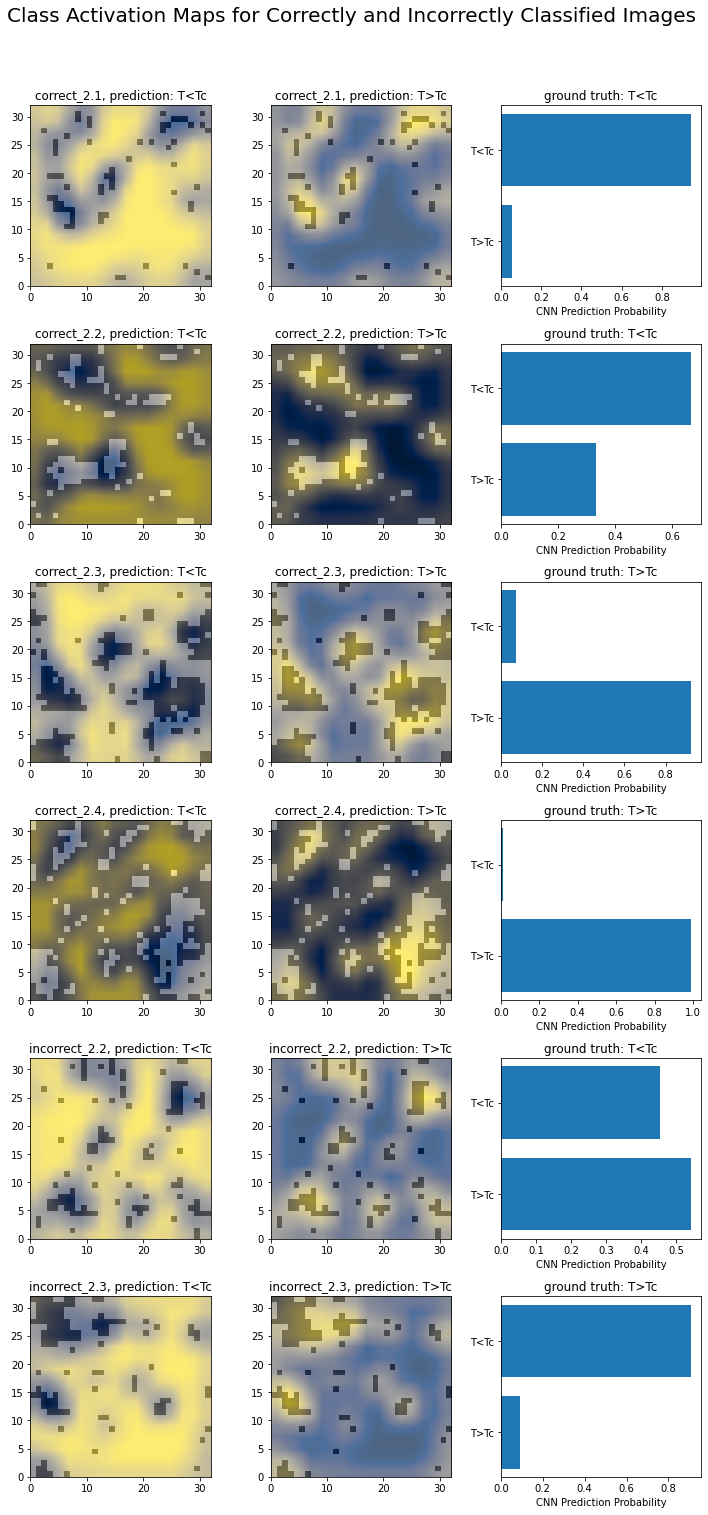

In [32]:
## calculate and plot class activation maps (CAMs) for the four images (2 maps for each image, one for > Tc, one for < Tc) 

#print(model.layers)
last_conv_layer = model.layers[-3]

inputs = [K.learning_phase()] + model.inputs

activation_func = K.function(inputs, [last_conv_layer.output])

# Get weights connecting output of GAP layer to final dense softmax layer
W, b = model.layers[-1].get_weights()

print('')

# plot class activation maps
fig, axes = plt.subplots(6, 3, figsize=(10, 20))
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, hspace=.1, wspace=.1)
# [0,1] = True = T>Tc
# [1,0] = False = T<Tc
for i in range(len(display)):
    key = list(display.keys())[i]
    X_in = np.expand_dims(display[key][0], axis=0)
    #print('X_in.shape:', X_in.shape)
    f,  = activation_func([0] + [X_in])
    # Define class activation map for both classes. 
    # M contains two 16x16 activation maps: 0 index for T>Tc, 1 index for T<Tc
    M = np.einsum('ixyz,zc->ixyc', f, W) + b
    #print('M.shape:', M.shape)
    ax1 = axes.flat[3*i]
    ax2 = axes.flat[3*i+1]
    ax3 = axes.flat[3*i+2]
    
    # M[:,:,:,0] is CAM for T<Tc since [1,0]=False=T<Tc
    ax1.imshow(np.squeeze(X_in), cmap='Greys', extent=(0, 32, 0, 32))
    ax1.imshow(np.squeeze(M[:,:,:,0]), interpolation='bilinear', alpha=.7, extent=(0, 32, 0, 32), cmap='cividis')
    ax1.set_title(key + ', prediction: T<Tc')
    
    # M[:,:,:,1] is CAM for T>Tc since [0,1]=True=T>Tc
    ax2.imshow(np.squeeze(X_in), cmap='Greys', extent=(0, 32, 0, 32))
    ax2.imshow(np.squeeze(M[:,:,:,1]), interpolation='bilinear', alpha=.7, extent=(0, 32, 0, 32), cmap='cividis')
    ax2.set_title(key + ', prediction: T>Tc')
    
    classes = ['T<Tc', 'T>Tc']
    class_ticks = np.arange(len(classes))
    probs = display[key][3]
    y = display[key][1]
    #print(probs)
    ax3.barh(class_ticks, probs, align='center')
    ax3.set_yticks(class_ticks)
    ax3.set_yticklabels(classes)
    ax3.invert_yaxis()
    ax3.set_xlabel('CNN Prediction Probability')
    ax3.set_title('ground truth: ' + str(classes[display[key][1]]))
    
    '''
    people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
    y_pos = np.arange(len(people))
    performance = 3 + 10 * np.random.rand(len(people))
    error = np.random.rand(len(people))

    ax.barh(y_pos, performance, xerr=error, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(people)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Performance')
    ax.set_title('How fast do you want to go today?')
    '''


fig.suptitle('Class Activation Maps for Correctly and Incorrectly Classified Images', y = 1.05, fontsize=20)
fig.tight_layout()
plt.show()
plt.savefig('output/CAMs.jpg')
plt.close()
